In [1]:
import numpy as np
import h5py

train_path = '../Data/KITTI_train/kitti_train_3.h5'
test_path = '../Data/KITTI_train/kitti_test_3.h5'

f = h5py.File(train_path, 'r')
X_train = np.asarray(list(f['data']))
Y_train = np.asarray(list(f['label']))

f = h5py.File(test_path, 'r')
X_test = np.asarray(list(f['data']))
Y_test = np.asarray(list(f['label']))

In [2]:
import copy
def norm(dim, val):
    i = copy.deepcopy(val)
    i -= np.min(i, axis=0)
    k = max(i[:,0]) - min(i[:,0])
    i[:,0] /= k
    k = max(i[:,1]) - min(i[:,1])
    i[:,1] /= k
    k = max(i[:,2]) - min(i[:,2])
    i[:,2] /= k
    return i*(dim-1)

X_test_points = [norm(32, i) for i in X_test]
X_train_points = [norm(32, i) for i in X_train]
print X_train_points[0]

# now we need to voxelize that point cloud...
def voxelize(dim, data):
    data = np.asarray([[int(i[0]), int(i[1]), int(i[2])] for i in data])
    data = np.unique(data, axis=1)
    retval = np.zeros((dim, dim, dim))
    for i in data:
        retval[i[0]][i[1]][i[2]] = 1
    retval = np.asarray([retval])
    return retval
    
X_train = [voxelize(32, i) for i in X_train_points]
X_train = np.asarray(X_train)
X_train = np.reshape(X_train, (-1, 32, 32, 32, 1))

X_test = [voxelize(32, i) for i in X_test_points]
X_test = np.asarray(X_test)
X_test = np.reshape(X_test, (-1, 32, 32, 32, 1))

#Y_test = [[0.0,1.0]if i[0] == 1.0 else [1.0, 0.0]  for i in Y_test]
#Y_train = [[0.0,1.0]if i[0] == 1.0 else [1.0, 0.0]  for i in Y_train]
#Y_test = np.asarray(Y_test)
#Y_train = np.asarray(Y_train)

print X_train.shape
print X_test.shape

[[ 0.6079998   5.30440167  9.86611774]
 [ 0.98399925  5.4773679  10.2665867 ]
 [ 6.67200089  0.76875307  9.42924291]
 ...
 [ 3.37599945  1.4798492   6.5531398 ]
 [ 1.69599915  9.16738904 10.79447947]
 [ 7.5359993   1.55672359 12.54198313]]
(2412, 32, 32, 32, 1)
(1568, 32, 32, 32, 1)


<IPython.core.display.Javascript object>


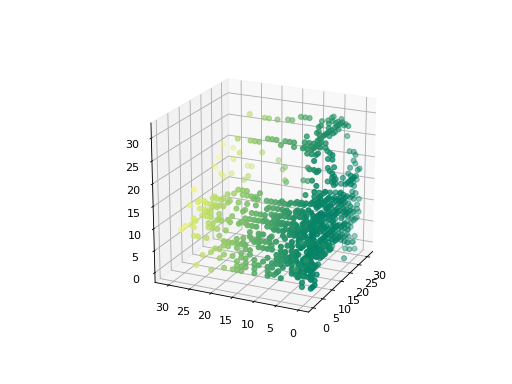

In [5]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

voxed = []
for i in range(32):
    for j in range(32):
        for k in range(32):
            if(X_train[0][i][j][k] == 1):
                voxed.append([i,j,k])

def show_fig(inp):
    inp = np.asarray(inp)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_aspect('equal')

    X,Y,Z = np.hsplit(inp,3)
    scat = ax.scatter(X,Y,Z,c=Y,cmap='summer')
    
    max_range = np.asarray([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()-X.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()-Y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()-Z.min())

    for xb,yb,zb in zip(Xb,Yb,Zb):
        ax.plot([xb],[yb],[zb], 'r')

    plt.grid()
    plt.show()
    
show_fig(voxed)


In [6]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Convolution3D, MaxPooling3D
from keras.layers import Conv3D
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import SGD
import random
import numpy as np

num_classes = 3

# Defining VoxNet in Keras 2
model = Sequential()
model.add(Conv3D(input_shape=(32, 32, 32, 1), filters=32, kernel_size=(5,5,5), strides=(2, 2, 2)))
model.add(Activation(LeakyReLU(alpha=0.1)))
model.add(Dropout(rate=0.3))
model.add(Conv3D(filters=32, kernel_size=(3,3,3)))
model.add(Activation(LeakyReLU(alpha=0.1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=None))
model.add(Dropout(rate=0.4))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=num_classes, kernel_initializer='normal', activation='relu'))
model.add(Activation("softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 14, 14, 14, 32)    4032      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 14, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 14, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 12, 12, 12, 32)    27680     
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 12, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 6, 6, 32)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 6, 32)       0         
__________

/usr/local/lib/python2.7/dist-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


In [ ]:
history = model.fit(x=X_train, y=Y_train, batch_size=32, 
                    epochs=10, verbose=1,
                    validation_data=(X_test, Y_test))

In [ ]:
print model.evaluate(X_test, Y_test)

In [ ]:
from keras.models import model_from_json
import os
#model_json = model.to_json()
#with open("voxnet_kitti.json", "w") as json_file:
#    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("VoxNet-KITTI3.h5")
print("Saved model to disk")